Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


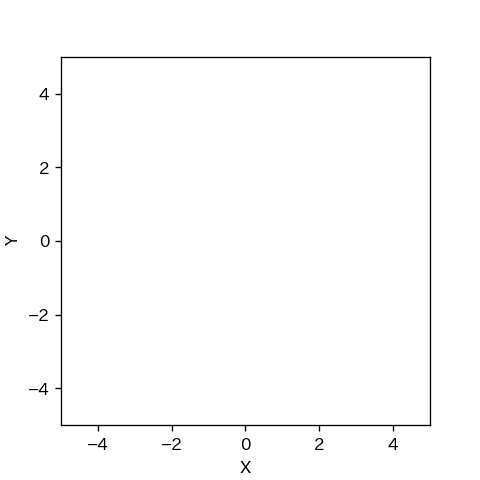

In [1]:
import sys
sys.path.append("../scripts/")
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        nearest_obs = np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id = observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p, self.map.landmarks[landmark_id].pos, *values)
            
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

In [3]:
def trial_trap(animation): ###mclkidnap1test
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([0,0,0]).T
    robot_pose=np.array([0,0,0]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m),agent=a,color="red",expected_stuck_time=5,expected_escape_time=5)
    world.append(r)
    
    world.draw()
    
    return(r.pose, pf.ml.pose)

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


<IPython.core.display.Javascript object>


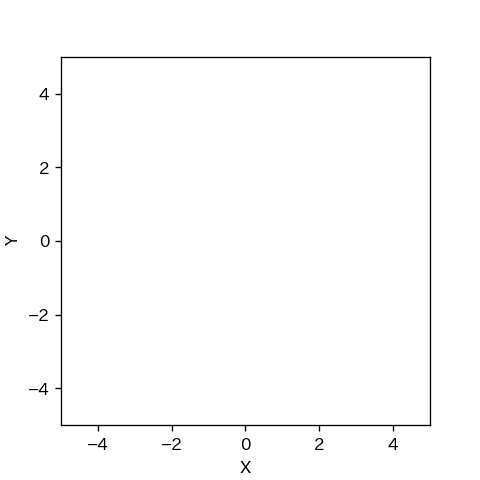

(array([0, 0, 0]), array([0, 0, 0]))

In [4]:
trial_trap(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_trap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

0 真値: [0.31732282 0.03326579 0.20890226] 推定値: [0.90611149 0.19677631 0.29674662] 誤差: 0.6110710159080401
1
1 真値: [-0.15095505  1.9280147   3.43483651] 推定値: [-1.29962696  2.67269909  3.68262212] 誤差: 1.3689419284623554
2 真値: [1.08485528 1.82240792 2.09829302] 推定値: [-0.18345599  3.62386241  2.51595816] 誤差: 2.203145874489008
3 真値: [0.02772169 2.57028277 3.28105424] 推定値: [-0.33189994  2.964546    3.45445369] 誤差: 0.5336395927576272
2
4 真値: [-0.14080321  2.44606654  3.1370205 ] 推定値: [-0.42300664  1.80932341  2.94260447] 誤差: 0.696477267747145
3
5 真値: [0.8720737  1.11731056 1.83595551] 推定値: [1.14167085 1.47478292 1.66115315] 誤差: 0.44773776975576174
4
6 真値: [-0.11774653  2.21264494  3.11996762] 推定値: [-1.41734743  3.12040687  3.53811077] 誤差: 1.5852426417538097
7 真値: [1.58177051 1.4942382  1.50097781] 推定値: [1.62321328 1.76756679 1.44417147] 誤差: 0.2764525604237808
5
8 真値: [-0.38790346  2.01126034  3.6335841 ] 推定値: [-0.38502755  1.89620623  3.57925023] 誤差: 0.11509004851751244
6
9 真値: [1.05000124 2.28

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


20 真値: [-1.28221537  1.29399387  4.38693656] 推定値: [-1.27361058  1.26232057  4.44184345] 誤差: 0.03282134305530021
16
21 真値: [-1.13242443  1.50931637  4.21287765] 推定値: [-0.88832544 -0.12117717  5.22234052] 誤差: 1.6486641515429796
22 真値: [-0.56164777  1.28753815  3.92738301] 推定値: [-0.61800578  1.53349161  3.96267985] 誤差: 0.252327815106302
17
23 真値: [0.45986174 1.84548109 2.32692438] 推定値: [-1.0094353   3.59786181  2.80979585] 誤差: 2.286847611600921
24 真値: [0.74916996 1.84642116 2.15646526] 推定値: [-7.98871922  4.61228821 -1.5102983 ] 誤差: 9.165191104219268
25 真値: [0.5507903  2.76448879 2.52973315] 推定値: [0.33349474 3.18142363 2.63647444] 誤差: 0.47016169561473864
18
26 真値: [0.07932919 3.04050179 3.34395991] 推定値: [0.54584843 2.681856   3.27554663] 誤差: 0.5884445587076678
19
27 真値: [0.9900857  2.07195191 2.1803058 ] 推定値: [0.6841669  1.87625416 2.27493398] 誤差: 0.36315826484796115
20
28 真値: [-0.0301816   1.82422502  3.10714313] 推定値: [-0.86598564  2.28058534  3.26222138] 誤差: 0.9522778633345401
21
29 真値: 